# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [18]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [19]:
# Load in the general demographics data.
genpop = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter = ';')
custpop = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter = ';')
# Load in the feature summary file.
featsumm = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter = ';')

#Quick verification the columns in the attribute column of the feature summary and general population match in content and order
col_list = featsumm['attribute'].tolist()
genpop_col_list = genpop.columns.tolist()

print(col_list == genpop_col_list)


True


In [20]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(genpop.shape)
#print(custpop.shape)
print(featsumm.shape)

#genpop.head()
#custpop.head()
#featsumm


(891221, 85)
(85, 4)


In [21]:
#custpop.sample(5)

In [22]:
#genpop.sample(5)

In [23]:
#custpop.describe()

In [24]:
#custpop.info()

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [25]:
genpop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [26]:
# Identify missing or unknown data values and convert them to NaNs.
featsumm.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


In [27]:
featsumm

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


After scanning the missing_or_unknown column strings are consistently indicated in list form with open/close brackets \[ \].
The distinct values are -1,0,9,X,XX. It is also possible that the list is empty presumably indicating no missing or unknown values for that feature.

In [28]:
for col in genpop.columns.tolist():
    #for each col... store string of missing/unknown values from feature summary
    missing = featsumm[featsumm['attribute'] == col].iloc[0, 3]
    
    #strip brackets, extract values and store as a list
    fillvals = missing.strip('[]').split(',')
    #Remove potential white space
    fillvals = [val.strip() for val in fillvals]
    
    #replacement requires list of replacement values to be same type as the values to be replaced
    dtype = genpop[col].dtype
    if np.issubdtype(dtype,np.number):
        fillvals = [pd.to_numeric(val) for val in fillvals]
    elif np.issubdtype(dtype,object):
        fillvals = [str(val) for val in fillvals]

    genpop[col].replace(fillvals,np.nan, inplace=True)

In [29]:
#NaNs appear to be correctly applied
genpop.sample(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
747393,2.0,4.0,2,1.0,2,1,5,1,3,4,2,NaN,10.0,0,1.0,6.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,5,3,1,2,3,5,7,1,2,6,5,6,1,3,3.0,0.0,NaN,2.0,3,6.0,1.0,0.0,6.0,NaN,6.0,9.0,6.0,0.0,1.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,3.0,0.0,3.0,2.0,1.0,6.0,3.0,3.0,3.0,2.0,0.0,6.0,623.0,1.0,4.0,3.0,1.0,3.0,4.0,3.0,4.0,8.0,3.0
103115,NaN,1.0,2,3.0,1,5,3,5,3,5,1,1995.0,9.0,0,3.0,29.0,9.0,10.0,5.0,2.0,1.0,2.0,14.0,2.0,5,4,4,4,1,2,2,3,6,7,7,6,7,6,3.0,0.0,NaN,2.0,4,21.0,2.0,0.0,6.0,3.0,1.0,8.0,59.0,0.0,3.0,2.0,1992.0,W,1.0,8,8A,51,0.0,0.0,0.0,1.0,NaN,1.0,2.0,6.0,4.0,3.0,2.0,1.0,5.0,3.0,232.0,2.0,4.0,2.0,1.0,5.0,2.0,2.0,3.0,4.0,5.0
421270,NaN,2.0,2,6.0,3,4,3,5,5,3,4,NaN,4.0,0,NaN,6.0,2.0,1.0,1.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
420266,1.0,3.0,2,2.0,3,1,5,1,1,5,6,1939.0,3.0,0,3.0,8.0,2.0,1.0,1.0,3.0,2.0,1.0,3.0,5.0,5,3,3,2,2,4,6,1,4,4,7,7,4,2,3.0,0.0,NaN,1.0,3,9.0,1.0,0.0,6.0,NaN,6.0,9.0,11.0,0.0,8.0,2.0,1992.0,O,2.0,8,8D,55,0.0,0.0,0.0,2.0,4.0,1.0,3.0,6.0,3.0,4.0,3.0,1.0,1.0,2.0,593.0,2.0,2.0,2.0,1.0,1.0,5.0,4.0,3.0,7.0,2.0
80291,NaN,2.0,2,4.0,4,3,4,4,3,1,6,1967.0,5.0,1,2.0,39.0,12.0,10.0,5.0,10.0,5.0,1.0,11.0,2.0,5,5,7,3,1,3,5,5,7,4,7,7,6,7,1.0,0.0,NaN,1.0,4,15.0,4.0,0.0,4.0,1.0,4.0,9.0,2.0,0.0,1.0,1.0,1992.0,W,1.0,9,9A,52,2.0,2.0,0.0,0.0,NaN,5.0,1.0,5.0,3.0,3.0,3.0,3.0,5.0,6.0,558.0,3.0,3.0,1.0,0.0,1.0,3.0,4.0,3.0,7.0,3.0
553006,NaN,1.0,1,4.0,1,5,2,5,5,5,1,NaN,3.0,1,2.0,3.0,1.0,1.0,1.0,5.0,2.0,1.0,15.0,4.0,7,7,7,3,7,3,2,7,4,1,1,1,7,5,1.0,0.0,NaN,1.0,1,NaN,0.0,0.0,5.0,NaN,NaN,9.0,3.0,0.0,3.0,1.0,1992.0,W,7.0,6,6B,43,3.0,2.0,0.0,0.0,1.0,3.0,7.0,3.0,8.0,2.0,2.0,3.0,3.0,3.0,1500.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,2.0
828583,NaN,2.0,2,5.0,3,4,3,5,5,3,4,NaN,4.0,0,NaN,9.0,3.0,1.0,1.0,7.0,3.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517895,1.0,3.0,2,2.0,2,1,5,1,2,5,2,1955.0,4.0,0,2.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,2.0,1,3,1,2,2,6,6,3,4,7,6,7,3,3,2.0,0.0,NaN,1.0,3,13.0,1.0,0.0,6.0,NaN,4.0,9.0,16.0,2.0,3.0,1.0,1992.0,W,4.0,6,6B,43,0.0,0.0,0.0,2.0,5.0,1.0,4.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,913.0,2.0,4.0,2.0,1.0,2.0,5.0,4.0,4.0,5.0,5.0
541677,NaN,3.0,2,2.0,4,2,3,3,2,1,6,1968.0,3.0,0,3.0,9.0,3.0,1.0,1.0,6.0,3.0,2.0,10.0,3.0,2,3,3,2,4,1,6,1,4,6,6,5,3,3,2.0,0.0,NaN,2.0,4,15.0,1.0,0.0,4.0,NaN,3.0,6.0,2.0,0.0,3.0,5.0,1992.0,W,7.0,2,2B,13,2.0,2.0,0.0,0.0,NaN,4.0,3.0,2.0,5.0,3.0,2.0,4.0,2.0,4.0,306.0,3.0,2.0,0.0,0.0,1.0,2.0,3.0,2.0,3.0,3.0
568532,NaN,1.0,1,6.0,3,4,3,5,5,3,4,NaN,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

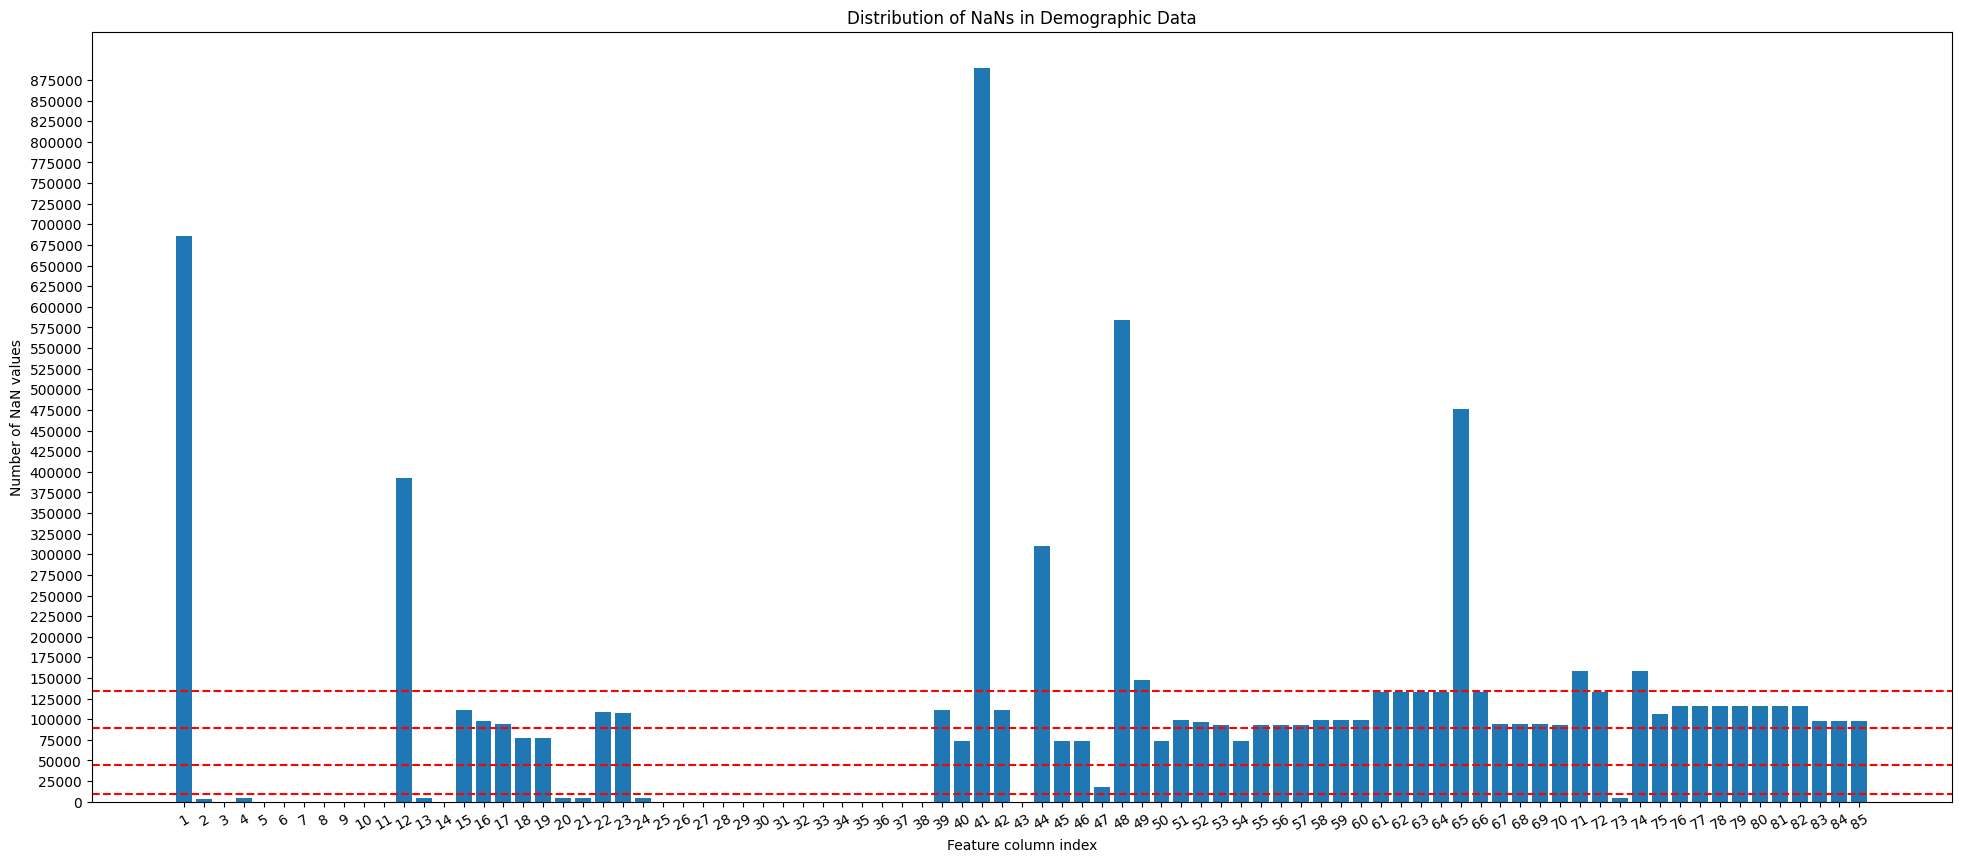

In [30]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

def distr_nans(df):
    
    #Obtain a series of sums of NaNs in each column of genpop dataframe
    nan_counts = df.isna().sum()
    
    plt.figure(figsize=(24, 10))

    plt.bar(range(1 ,nan_counts.shape[0]+1),nan_counts.values);

    plt.xticks(range(1 ,nan_counts.shape[0]+1), rotation=30, ha = 'center');
    plt.yticks(range(0,nan_counts.max(),25000));

    plt.axhline(y=0.15*df.shape[0], color='r', linestyle='--');
    plt.axhline(y=0.1*df.shape[0], color='r', linestyle='--');
    plt.axhline(y=0.05*df.shape[0], color='r', linestyle='--');
    plt.axhline(y=0.01*df.shape[0], color='r', linestyle='--');

    plt.title('Distribution of NaNs in Demographic Data');
    plt.xlabel('Feature column index');
    plt.ylabel('Number of NaN values');
    
distr_nans(genpop)



A bar plot seems more appropriate for identifying columns with excessive numbers of NaN values than the histogram. 

It was discovered by plotting the above that the columns 1, 12, 41, 44, 48, and 65 have a very large proportion of missing values. An arbitrary threshhold line of 133683 NaN values was drawn as a cut-off via visual inspection (this represents 15% of the total number of samples (891221)).

Columns 49, 71, and 74 skirt just over this threshhold line.



In [31]:
#Indexed values are from 0; column numbers above subtracted by 1:
nan_counts = genpop.isna().sum()
outlier_feats = nan_counts.index[[0,11,40,43,47,64]].tolist()
threshhold_feats = nan_counts.index[[48,70,73]].tolist()

print(outlier_feats)
print(threshhold_feats)


['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
['W_KEIT_KIND_HH', 'KKK', 'REGIOTYP']


Text(0.5, 1.0, 'Neighborhood typology')

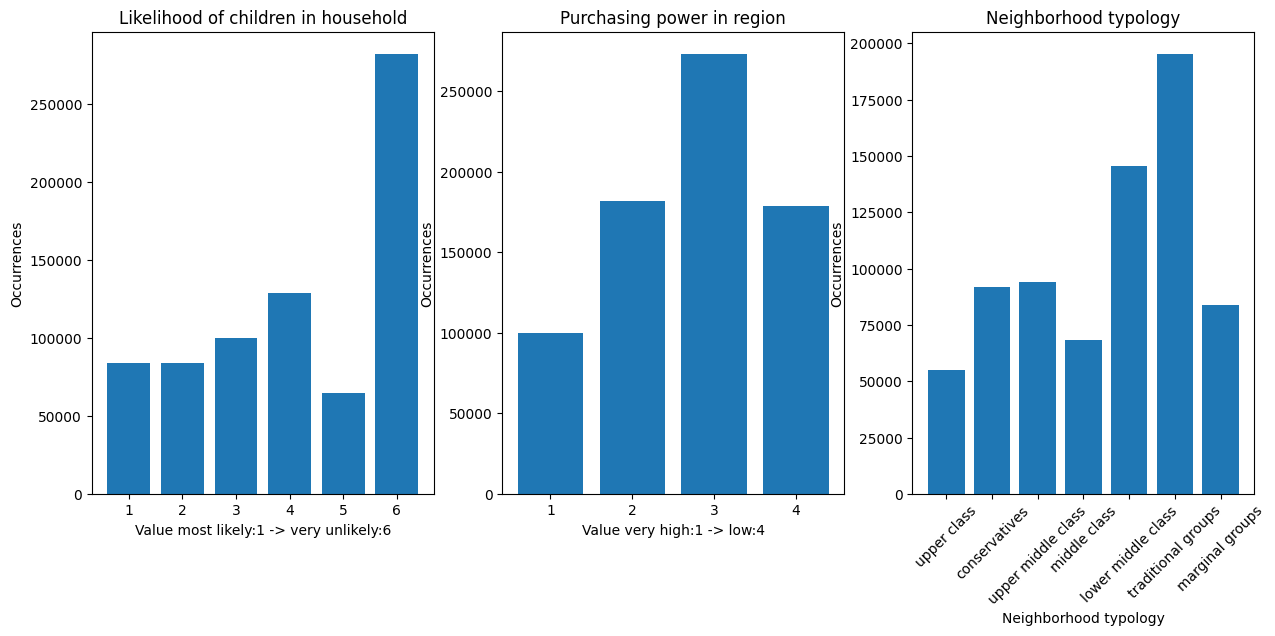

In [32]:
fig,axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15,6))
value_counts = []

value_counts.append(genpop['W_KEIT_KIND_HH'].value_counts().sort_index())
value_counts.append(genpop['KKK'].value_counts().sort_index())
value_counts.append(genpop['REGIOTYP'].value_counts().sort_index())
nbh_typ = ['upper class','conservatives','upper middle class','middle class','lower middle class', 'traditional groups', 'marginal groups']

axes[0].bar(value_counts[0].index, value_counts[0].values)
axes[0].set_ylabel('Occurrences')
axes[0].set_xlabel('Value most likely:1 -> very unlikely:6')
axes[0].set_title('Likelihood of children in household')

axes[1].bar(value_counts[1].index, value_counts[1].values)
axes[1].set_ylabel('Occurrences')
axes[1].set_xlabel('Value very high:1 -> low:4')
axes[1].set_title('Purchasing power in region')

axes[2].bar(value_counts[2].index, value_counts[2].values)
axes[2].set_ylabel('Occurrences')
axes[2].set_xlabel('Neighborhood typology')
axes[2].set_xticks(value_counts[2].index)
axes[2].set_xticklabels(nbh_typ, rotation = 45)
axes[2].set_title('Neighborhood typology')


Naively and without domain knowledge it is hard to judge how much impact the threshhold features will have on developing good clusters between the demographics and the customer data. They seem like they could be useful metrics. The purchasing power in region data may be the least useful since it follows a near normal distribution on a scale of 1 to 4 with a a slight skew toward low purchasing power as to be expected.

The two-mode nature of the Neighborhood typology might be useful for clustering conservatives / upper middle class and lower middle class with traditional groups. The relatively high occurrences of very unlikely to have children might be interesting.


In [33]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

outlier_indices = [0,11,40,43,47,64]
genpop = genpop.drop(genpop.columns[outlier_indices], axis=1)
print(genpop.shape)
genpop.sample(10)

(891221, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
719380,3.0,2,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27321,4.0,1,6.0,3,1,5,1,2,4,5,8.0,0,1.0,24.0,7.0,8.0,4.0,1.0,1.0,1.0,8.0,4.0,6,4,2,4,7,7,3,4,1,3,3,3,4,4,3.0,0.0,1.0,4,4.0,0.0,4.0,1.0,9.0,11.0,0.0,1.0,1.0,1992.0,W,3.0,7,7A,41,0.0,0.0,0.0,2.0,1.0,1.0,6.0,3.0,3.0,3.0,1.0,5.0,6.0,533.0,1.0,4.0,3.0,2.0,5.0,4.0,2.0,3.0,9.0,5.0
390440,1.0,1,1.0,2,5,3,5,5,3,1,10.0,1,2.0,10.0,3.0,1.0,1.0,10.0,5.0,1.0,15.0,3.0,7,7,7,5,6,3,2,7,4,2,2,2,7,5,1.0,0.0,2.0,1,1.0,0.0,5.0,6.0,8.0,2.0,0.0,1.0,3.0,1992.0,W,2.0,6,6B,43,3.0,2.0,0.0,0.0,3.0,1.0,6.0,2.0,5.0,3.0,3.0,3.0,7.0,404.0,2.0,3.0,2.0,0.0,1.0,3.0,3.0,5.0,8.0,5.0
834170,4.0,1,3.0,3,4,1,2,4,3,4,1.0,0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,14.0,3.0,3,6,2,6,6,7,7,6,3,3,3,2,2,4,3.0,0.0,2.0,5,1.0,0.0,6.0,6.0,4.0,10.0,0.0,3.0,2.0,1992.0,W,5.0,9,9D,51,0.0,3.0,2.0,0.0,2.0,1.0,6.0,3.0,3.0,3.0,2.0,2.0,7.0,432.0,1.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,9.0,4.0
490685,1.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,3.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38590,3.0,1,3.0,5,1,5,1,1,2,5,5.0,0,3.0,19.0,5.0,2.0,2.0,9.0,4.0,1.0,5.0,5.0,6,5,4,4,7,4,4,5,2,5,2,3,4,2,0.0,0.0,2.0,3,2.0,0.0,5.0,6.0,9.0,2.0,0.0,1.0,4.0,1992.0,W,4.0,1,1A,13,1.0,2.0,0.0,0.0,3.0,2.0,5.0,5.0,5.0,3.0,3.0,1.0,6.0,395.0,2.0,3.0,1.0,0.0,5.0,3.0,4.0,4.0,6.0,3.0
327467,4.0,2,2.0,2,1,4,2,1,5,6,11.0,0,2.0,6.0,2.0,1.0,1.0,1.0,1.0,1.0,5.0,5.0,1,1,1,2,2,7,7,1,3,7,5,6,1,3,3.0,0.0,2.0,3,1.0,0.0,6.0,6.0,8.0,10.0,0.0,3.0,1.0,1994.0,O,4.0,8,8C,54,0.0,3.0,2.0,0.0,2.0,1.0,6.0,2.0,2.0,3.0,2.0,0.0,5.0,182.0,1.0,3.0,3.0,1.0,3.0,2.0,1.0,4.0,9.0,3.0
774215,3.0,1,5.0,1,5,3,5,4,5,1,12.0,0,NaN,NaN,NaN,1.0,1.0,2.0,1.0,NaN,NaN,5.0,4,6,7,5,4,5,3,4,4,4,4,4,6,4,NaN,0.0,NaN,4,1.0,0.0,6.0,NaN,9.0,9.0,0.0,1.0,2.0,1992.0,W,5.0,9,9C,51,0.0,3.0,2.0,1.0,2.0,7.0,6.0,3.0,3.0,4.0,1.0,1.0,6.0,289.0,1.0,4.0,3.0,2.0,4.0,3.0,2.0,4.0,7.0,5.0
89824,2.0,1,4.0,2,5,1,5,5,3,4,12.0,0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,14.0,4.0,7,7,6,3,6,3,3,7,4,2,4,3,7,5,1.0,0.0,2.0,5,1.0,0.0,6.0,4.0,2.0,11.0,0.0,1.0,5.0,1992.0,W,3.0,9,9B,51,1.0,2.0,1.0,0.0,3.0,6.0,4.0,6.0,4.0,3.0,3.0,3.0,5.0,1058.0,2.0,3.0,2.0,1.0,1.0,5.0,5.0,4.0,5.0,5.0
558056,1.0,1,5.0,1,5,2,5,4,5,1,1.0,0,3.0,30.0,9.0,10.0,5.0,4.0,2.0,1.0,14.0,3.0,7,7,7,5,7,2,2,7,4,2,2,2,6,5,1.0,0.0,2.0,4,2.0,0.0,4.0,4.0,9.0,4.0,0.0,1.0,7.0,1992.0,O,7.0,4,4C,24,3.0,0.0,1.0,0.0,5.0,7.0,1.0,6.0,5.0,4.0,4.0,4.0,4.0,85.0,3.0,1.0,0.0,0.0,1.0,1.0,2.0,5.0,1.0,3.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

Consulting the data dictionary, the outlier features refer to (in the order they appear in the list in the cells above): <br>
**Person-level features**<br>
Best-ager typology<br> 
Year of birth<br>
Academic title flag<br>
**Household-level features**<br>
Birthdate of head of household<br>
Consumer pattern over past 12 months<br>
**RR3 micro-cell feature**<br>
Most common building type within the microcell<br>
<br>
The threshhold features are:<br>
**Household-level feature**:<br>
Likelihood of children in household<br>
**RR1 region features**:<br>
Purchasing power in region<br>
Neighborhood typology (identifying neighborhood class)



Minus the outlier features above, the rest of the features typically fall into two ranges for the amount of unknown / missing values: <br>
**Around 0-1% unknown / missing values:** <br>
Features 2-11,13-14,20-21,24-38,43,47,73<br>
**Around 10-15% unknown / missing values:**<br>
Features 15-19, 22-23,39-40,42,45-46,49-64,66-72,74-85<br>
<br>
Per the data dictionary<br>
Features 2-11 are related: Financial typology.<br>
Features 25-38 are related: Personality typology<br>
Features 61-66 are related: Number of family houses / buildings in RR3 microcell. Notably the relative value of most<br> common building type is one of the outlier features (feature 65) but the total number of buildings in the microcell (feature 66) is in line with features 61-64.<br>
Features 76-82 are related: Number of family houses / buildings in PLZ8 macro-cell. Unlike features<br> 61-66, the relative feature of most common building type is not an outlier feature.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [34]:
# How much data is missing in each row of the dataset?
nan_counts_rows = genpop.isna().sum(axis=1)
#nan_counts_rows.sample(50)
cust_qrtl = [0.75,0.8,0.85,0.87,0.88,0.89,0.9,0.95]
nan_counts_rows.describe(percentiles=cust_qrtl)


count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
50%           0.000000
75%           3.000000
80%           5.000000
85%           8.000000
87%          10.000000
88%          13.000000
89%          16.000000
90%          34.000000
95%          47.000000
max          49.000000
dtype: float64

In [35]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#89th percentile data P89
P89_genpop = genpop[nan_counts_rows <= nan_counts_rows.quantile(0.89)]
#Complement of the 89th percentile data CP89
CP89_genpop = genpop[nan_counts_rows > nan_counts_rows.quantile(0.89)]

In [36]:
print(genpop.shape)
print(P89_genpop.shape)
print(CP89_genpop.shape)


(891221, 79)
(794792, 79)
(96429, 79)


In [37]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_col(col):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
    sns.countplot(data = P89_genpop,x = col, ax = axes[0])
    sns.countplot(data = CP89_genpop, x = col, ax = axes[1])
    
    axes[0].set_title('Data samples with few missing values')
    axes[1].set_title('Data samples with many missing values')
    
        
    plt.tight_layout()
    plt.show()


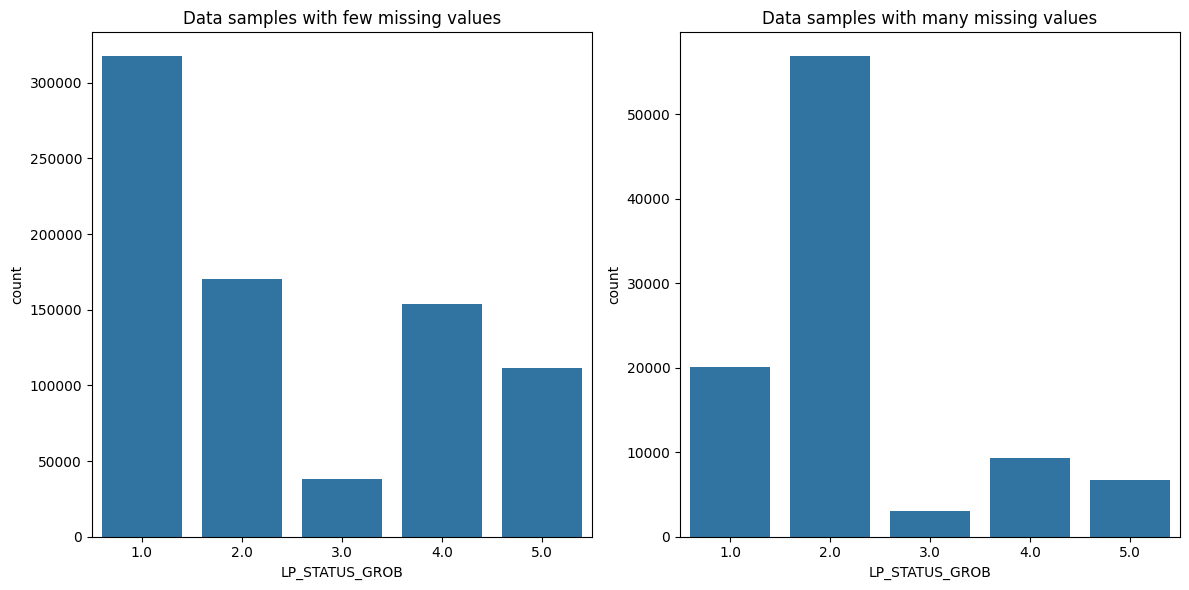

In [38]:
#compare_col('ZABEOTYP')
#compare_col('HH_EINKOMMEN_SCORE')
#compare_col('ONLINE_AFFINITAET')
#compare_col('FINANZTYP')
compare_col('LP_STATUS_GROB')

In [39]:
#Continuing analysis by dropping the group of rows with more than 16 missing values (89th percentile complement)
genpop = P89_genpop
genpop.reset_index(drop=True, inplace=True)
genpop.shape

(794792, 79)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Missing feature data per row ranges from 0 to a maximum of 49 values. There are quite a few rows with little to no missing values (The 3rd quartile is 3 missing values). About 10% of the data has 34 missing features or more.

The jump in the number of missing values is most extreme between the 89th and 90th percentile. I decided to make the 89th percentile the threshhold and split the data on either side.


These were the columns I compared each of which containing a low number of NaNs: <br>
Non-Ordinal: Energy consumption typology (ZABEOTYP)<br>
Ordinal: Estimated household net income (HH_EINKOMMEN_SCORE)<br>
Ordinal: Online affinity (ONLINE_AFFINITAET)<br>
Non-Ordinal: Most descriptive financial type for individual (FINANZTYP)<br>
Ordinal: Social status rough scale (LP_STATUS_GROB)
<br>
<br>
**Energy consumption:** 'fair supplied' appears to be over-represented in the high missing values group. Other categories appear under-represented as well (particularly 'green' and 'price driven'<br>
**Estimated household net income:** Data very different between the groups. Low missing value group follows expected low count to high count curve from high income to low income. High missing value group is just a large spike in values at 'very high income' with other values not very present at all indicating possible bias.<br>
**Online affinity:** The group with low missing values is distributed uniformly. The group with high missing data spikes aggressively at 'middle' with other values being comparably much smaller.<br>
**Most descriptive financial type:** The group with low missing values shows spikes in 'low financial interest' and 'inconspicuous'. The high missing values group appears to under-represent these values and over-represent 'be prepared'.<br>
**Social status (rough scale):** The distribution of values are similar between the two groups. The main difference being the low missing value group has a greater count of 'low-income earners' and the high issing value group has a greater count of 'average earners'.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [40]:
featsumm.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [41]:
# How many features are there of each data type?

#Dropping outlier indices identified in step above from feature summary
outlier_indices = [0,11,40,43,47,64]
featsumm_d = featsumm.drop(outlier_indices)

cat_mix = featsumm_d[featsumm_d['type'].isin(['categorical','mixed'])]

#18 categorical features
print(cat_mix[cat_mix['type'] == 'categorical'].shape[0])
#6 mixed features
print(cat_mix[cat_mix['type'] == 'mixed'].shape[0])

cat_mix


18
6


,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [42]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#Binary categoricals
bin_cat = ['ANREDE_KZ','GREEN_AVANTGARDE','SOHO_KZ','VERS_TYP']

#OST_WEST_KZ is binary but needs to be re-encoded from O and W to 0 and 1

#Multi-level categoricals
mult_cat = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN',
            'LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015']

#CAMEO_DEU_2015 is a multi-level categorical that is a fine scale of CAMEO_DEUG_2015. It will be dropped as it 
#contains 46 unique values and the rough scale of the data already exists in the dataset.




In [43]:
genpop[mult_cat].head()

,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,ZABEOTYP,GEBAEUDETYP,CAMEO_DEUG_2015
0,5.0,1,10.0,5.0,3.0,2.0,1.0,1.0,3.0,5,8.0,8
1,3.0,1,10.0,1.0,1.0,3.0,2.0,1.0,2.0,5,1.0,4
2,2.0,6,1.0,NaN,NaN,9.0,4.0,1.0,1.0,3,1.0,2
3,5.0,5,5.0,10.0,5.0,3.0,2.0,1.0,2.0,4,1.0,6
4,2.0,2,1.0,1.0,1.0,4.0,2.0,1.0,0.0,4,1.0,8


In [44]:
#encoding the multi categorical features

#Instantiating the encoder
encoder = OneHotEncoder(sparse_output=False)

#fitting and transforming the relevant multi-category features with the encoder
df_mult_cat = genpop[mult_cat]
encoded_array = encoder.fit_transform(df_mult_cat)

#Forming a dataframe out of the new one-hot columns
df_encoded = pd.DataFrame(encoded_array,columns = encoder.get_feature_names_out(mult_cat))

#Removing columns created by categorizing the NaNs. OneHotEncoder unfortunately doesnt seem to have a parameter
#to ignore NaNs.
nan_columns = [col for col in df_encoded.columns if '_nan' in col]
df_encoded = df_encoded.drop(columns = nan_columns)

#Interestingly, the number of columns is 84 and not 85. By adding up the encodings and subtracting the NaN columns
#We would expect 85 columns here. Upon further searching it was discovered the GEBAEUDETYP feature column
#does not contain any data entries of '7' ('company building') and thus the encoder did not create a column for 
#this value. This was confirmed true of the original raw dataset as well.
df_encoded.shape

#Dropping the 12 original columns we one-hot encoded
genpop = genpop.drop(columns=mult_cat)

#Concatenating our one-hot columns to the genpop dataframe
genpop = pd.concat([genpop,df_encoded],axis=1)

print(genpop.shape)
genpop.head()



(794792, 151)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
0,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,W,4.0,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,W,2.0,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,W,7.0,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0

In [45]:
# Re-encode categorical variable(s) to be kept in the analysis.

#Re-encoding OST_WEST_KZ
mapping = {'O': 0, 'W': 1}
genpop['OST_WEST_KZ'] = genpop['OST_WEST_KZ'].map(mapping)


In [46]:
#Dropping CAMEO_DEU_2015
genpop.drop(columns='CAMEO_DEU_2015',inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

Five binary categorical variables were identified. Four were left as is since they were numerical. OST_WEST_KZ was non-numerical 'O' and 'W' and was encoded as 0 for East and 1 for West. 

CAMEO_DEU_2015 is a finer scale of CAMEO_DEUG_2015 'German CAMEO: Wealth / Life Stage Typology'.
Since the rougher scale already exists and the feature is split among 46 unique values I chose to drop this feature from the analysis. It could be encoded via multiple dummy variables for future analyses if desired.

One-hot encoding was used on the remainder of the multi-categorical variables. NaN columns needed to be removed as the encoder considered NaNs as categories of data. Shapes of the dataframes were checked throughout processing to ensure consistency. It was here it was discovered that GEBAEUDETYP did not contain the value '7' anywhere resulting in one less column than expected. 

The genpop dataframe contained a total of 150 columns after removing the original columns and CAMEO_DEU_2015 and adding the one hot columns.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [47]:
cat_mix[cat_mix['type']=='mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [48]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

value_to_decade_mapping = {(1,2): 1940,(3,4): 1950,(5,6,7): 1960,(8,9): 1970,(10,11,12,13): 1980,(14,15): 1990}

def decade_mapping(value):
    for key, decade in value_to_decade_mapping.items():
        if value in key:
            return decade
    return np.nan

genpop['PRAEGENDE_JUGENDJAHRE_DECADE'] = genpop['PRAEGENDE_JUGENDJAHRE'].apply(decade_mapping)

#0 = Mainstream, 1 = Avantgarde
value_to_movement_mapping = {(1,3,5,8,10,12,14): 0, (2,4,6,7,9,11,13,15):1}

def movement_mapping(value):
    for key,movement in value_to_movement_mapping.items():
        if value in key:
            return movement
    return np.nan    

genpop['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = genpop['PRAEGENDE_JUGENDJAHRE'].apply(movement_mapping)

#removing original feature and keeping the two engineered features encoding decade and movement.
genpop.drop(columns='PRAEGENDE_JUGENDJAHRE',inplace = True)


In [49]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

#CAMEO_INTL_2015 feature was of object type instead of integer/float.
#converting to float for easier manipulation and for PCA later.
genpop['CAMEO_INTL_2015'] = genpop['CAMEO_INTL_2015'].astype(float)

def wealth_mapping(value):
    if pd.isna(value):
        return np.nan
    else:
        #tens place maps to wealth 1 thru 5: wealthy -> poorer
        return value // 10
    
def life_stage_mapping(value):
    if pd.isna(value):
        return np.nan
    else:
        #1s place maps to life stage 1 thru 5: prefamily couple/singles -> elders in retirement
        return value % 10   

genpop['CAMEO_INTL_2015_WEALTH'] = genpop['CAMEO_INTL_2015'].apply(wealth_mapping)
genpop['CAMEO_INTL_2015_LIFE_STAGE'] = genpop['CAMEO_INTL_2015'].apply(life_stage_mapping)

#removing original feature and keeping the two engineered features encoding decade and movement.
genpop.drop(columns='CAMEO_INTL_2015',inplace = True)


<Axes: xlabel='WOHNLAGE', ylabel='count'>

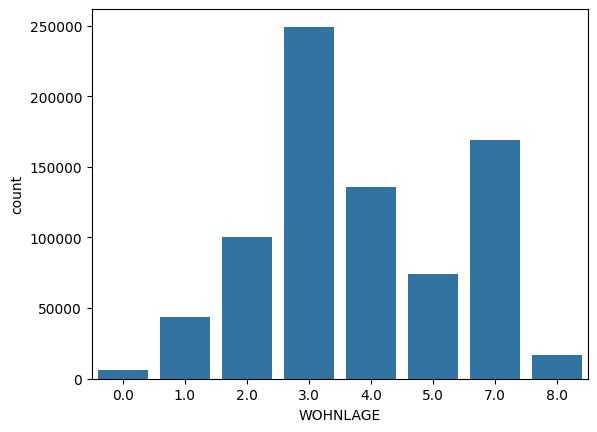

In [50]:
sns.countplot(data = genpop,x = genpop['WOHNLAGE'])

<Axes: xlabel='PLZ8_BAUMAX', ylabel='count'>

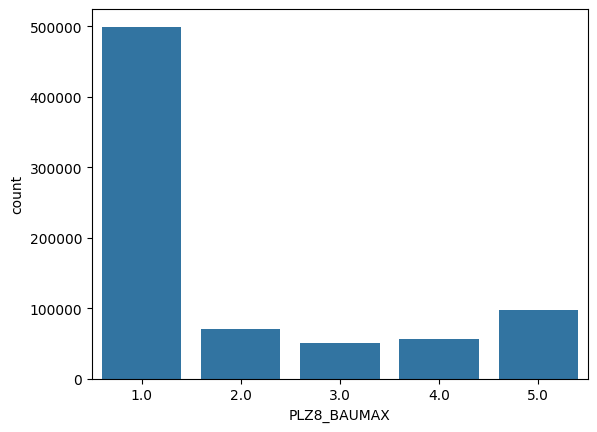

In [51]:
sns.countplot(data = genpop,x = genpop['PLZ8_BAUMAX'])

In [52]:
genpop.drop(columns = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'],inplace = True)

In [53]:
#Added 4 columns removed 6 columns.
genpop.shape

(794792, 148)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Dropped LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB to simplify analysis. Would have liked to include these features, but I was having too much difficulty in separating the data into meaningful and accurate new features.

Dropped WOHNLAGE. The feature is split between an ordinal of values 1 to 5 very good -> very poor neighborhoods and 2 non-ordinal values indicating rural neighborhood and new building in rural neighborhood.<br>
The rural neighborhood flag cannot be meaningfully detached from the feature as the countplot indicates approximately 150K known instances of rural and no corresponding verified values of 'not rural' eliminating its potential as a binary variable. If it were split into its own column this would result in the feature being mostly missing values. <br>
The ordinal component of the feature for quality of neighborhoods follows a normal distribution centered around an average neighborhood value of 3 which suggests the feature may not be very insightful.

Dropped PLZ8_BAUMAX. The mainly business buildings value clouds the clarity of the feature when the rest of the feature is ordinal in nature and focused around explicitly family homes. 

Engineered variables PRAEGENDE_JUGENDJAHRE_MOVEMENT and PRAEGENDE_JUGENDJAHRE_DECADE out of PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_WEALTH out of CAMEO_INTL_2015. Removed the original columns from which these features were engineered.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [54]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [55]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#genpop.sample(20)
genpop.describe()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
count,792049.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.00000,794792.000000,758707.000000,790298.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.00000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,758707.000000,794792.000000,794792.000000,794792.000000,736404.000000,794792.000000,788582.000000,791173.000000,794736.000000,794792.000000,794792.000000,757792.000000,757792.000000,757792.000000,757792.000000,757792.000000,794217.000000,794217.000000,794217.000000,794787.000000,732211.000000,757792.000000,790298.000000,732211.000000,784459.000000,774545.000000,774545.000000,774545.000000,774545.000000,774545.000000,774545.000000,790612.000000,790709.000000,790612.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794792.000000,794

In [56]:
#genpop only contains float and integer dtypes now
genpop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794792 entries, 0 to 794791
Columns: 148 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_LIFE_STAGE
dtypes: float64(125), int64(23)
memory usage: 897.4 MB


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [57]:
def clean_data(df,handle_nans = False):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:

    # ***Convert missing value codes into NaNs***

    for col in df.columns.tolist():
    #for each column store string of missing/unknown values from feature summary
        missing = featsumm[featsumm['attribute'] == col].iloc[0, 3]
        
        #strip brackets, extract values and store as a list
        fillvals = missing.strip('[]').split(',')
        #Remove potential white space
        fillvals = [val.strip() for val in fillvals]
        
        #replacement requires list of replacement values to be same type as the values to be replaced
        dtype = df[col].dtype
        if np.issubdtype(dtype,np.number):
            fillvals = [pd.to_numeric(val) for val in fillvals]
        elif np.issubdtype(dtype,object):
            fillvals = [str(val) for val in fillvals]

        df[col].replace(fillvals,np.nan, inplace=True)

    # ***Remove selected columns and rows***

    #Removing outlier features
    outlier_feats = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(columns = outlier_feats)
    
    #Keeping 89th percentile data rows (P89)
    nan_counts_rows = df.isna().sum(axis=1)
    P89_df = df[nan_counts_rows <= nan_counts_rows.quantile(0.89)]
    df = P89_df
    df.reset_index(drop=True,inplace = True)

    #Multi-level categorical features
    mult_cat = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN',
            'LP_STATUS_GROB','NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015']

    #Instantiating the encoder
    encoder = OneHotEncoder(sparse_output=False)

    #fitting and transforming the relevant multi-category features with the encoder
    df_mult_cat = df[mult_cat]
    encoded_array = encoder.fit_transform(df_mult_cat)

    #Forming a dataframe out of the new one-hot columns
    df_encoded = pd.DataFrame(encoded_array,columns = encoder.get_feature_names_out(mult_cat))

    #Removing columns created by categorizing the NaNs. OneHotEncoder unfortunately doesnt seem to have a parameter
    #to ignore NaNs.
    nan_columns = [col for col in df_encoded.columns if '_nan' in col]
    df_encoded = df_encoded.drop(columns = nan_columns)

    #Dropping the 12 original columns we one-hot encoded
    df = df.drop(columns=mult_cat)

    #Concatenating our one-hot columns to the dataframe
    df = pd.concat([df,df_encoded],axis=1)

    #Re-encoding OST_WEST_KZ
    mapping = {'O': 0, 'W': 1}
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map(mapping)

    #Dropping CAMEO_DEU_2015
    df.drop(columns='CAMEO_DEU_2015',inplace=True)
    
    # ***Select, re-encode, and engineer column values***

    #Engineering Decade and Movement variables from PRAEGENDE_JUGENDJAHRE

    value_to_decade_mapping = {(1,2): 1940,(3,4): 1950,(5,6,7): 1960,(8,9): 1970,(10,11,12,13): 1980,(14,15): 1990}

    def decade_mapping(value):
        for key, decade in value_to_decade_mapping.items():
            if value in key:
                return decade
        return np.nan

    #0 = Mainstream, 1 = Avantgarde
    value_to_movement_mapping = {(1,3,5,8,10,12,14): 0, (2,4,6,7,9,11,13,15):1}

    def movement_mapping(value):
        for key,movement in value_to_movement_mapping.items():
            if value in key:
                return movement
        return np.nan    

    #Applying the mappings for the newly engineered features
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(decade_mapping)
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(movement_mapping)

    #Removing original PRAEGENDE_JUGENDJAHRE feature
    df.drop(columns='PRAEGENDE_JUGENDJAHRE',inplace = True)

    #Engineering Wealth and Life Stage variables from CAMEO_INTL_2015

    #Converting CAMEO_INTL_2015 feature to float.
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)

    def wealth_mapping(value):
        if pd.isna(value):
            return np.nan
        else:
            #tens place maps to wealth 1 thru 5: wealthy -> poorer
            return value // 10
        
    def life_stage_mapping(value):
        if pd.isna(value):
            return np.nan
        else:
            #1s place maps to life stage 1 thru 5: prefamily couple/singles -> elders in retirement
            return value % 10   

    #Applying the mappings for the newly engineered features
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(wealth_mapping)
    df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(life_stage_mapping)

    #Removing original CAMEO_INTL_2015 feature
    df.drop(columns='CAMEO_INTL_2015',inplace = True)

    #Dropping remaining mixed type features
    df.drop(columns = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'],inplace = True)

    # Return the cleaned dataframe if handle_nans is false, otherwise remove NaNs by imputing and dropping NaNs
    if handle_nans == False:
        return df
    else:
        #In temp df drop nans
        df_temp = df.dropna()

        scaler = StandardScaler()

        #Fit the data without the NaNs
        df_nonans_scaled = scaler.fit(df_temp)

        #Transform the original data with NaNs using the fit generated from the data without the NaNs
        df_scaled = df_nonans_scaled.transform(df)

        #Convert array back to dataframe format
        df = pd.DataFrame(df_scaled,columns = df.columns)

        #Creating a list of features still containing NaNs in our dataframe
        feats_with_nans = df.columns[df.isnull().any()].tolist()

        #Checking types from featsumm for each of these features
        types = []
        for attr in feats_with_nans[:31]:
            types.append(featsumm[featsumm['attribute']==attr].iloc[0,2] + ' ' + attr )

        imputer_mean = SimpleImputer(strategy='mean')

        # columns for mean imputation
        cols_to_impute = [col for col in feats_with_nans if col not in ['VERS_TYP', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT']]

        # imputation step
        df[cols_to_impute] = imputer_mean.fit_transform(df[cols_to_impute])

        #Performing final dropping 
        df.dropna(inplace=True)
        df.reset_index(drop=True,inplace=True)

        #return clean df with remainder of NaNs handled
        return df


The following three cells were crashing the kernel in the Udacity workspace environment but were working on my local machine.
Confirmed that the cleanup routine creates the same dataframe as the above cleaning steps.

In [58]:
#genpop_base= pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter = ';')

In [59]:
#lurp = clean_data(genpop_base)

In [60]:
#This test confirms the clean_data routine is performing the same steps as the above data cleaning.
#Note the fillna is necessary since when comparing NaN values False is returned.
#print((genpop.fillna(0) == lurp.fillna(0)).all().all())

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

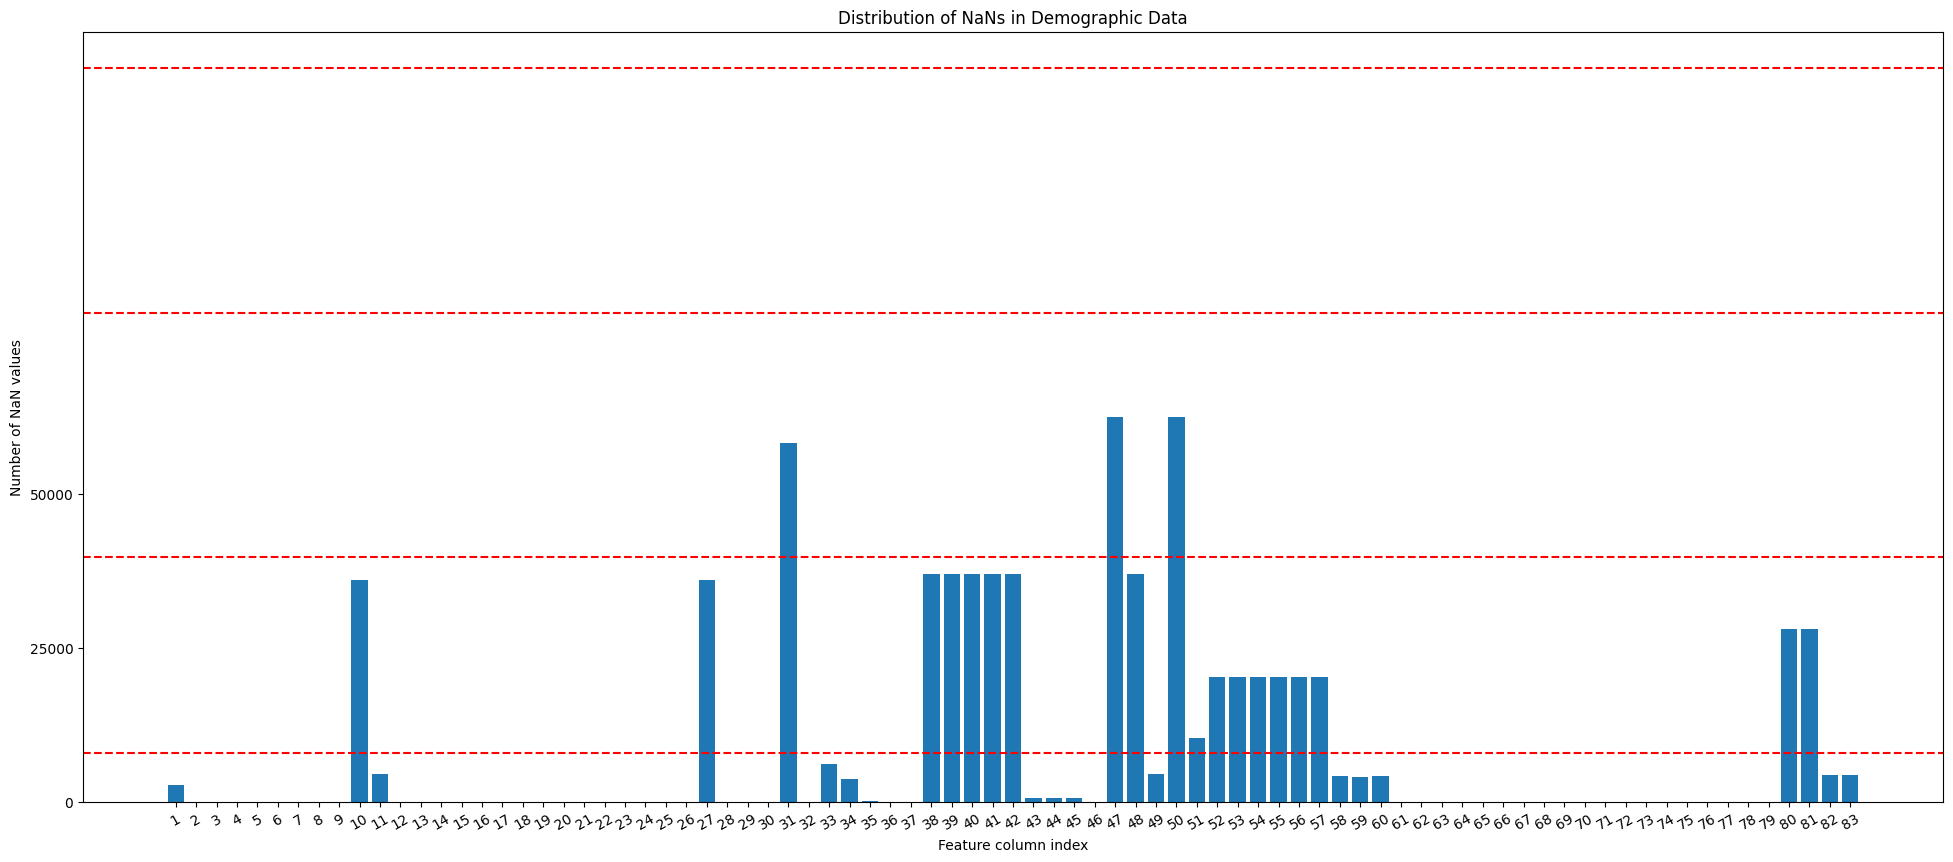

In [61]:
#dataframe minus onehot columns for visibility
genpop_minus_hot = pd.concat([genpop.iloc[:,:79],genpop.iloc[:,144:148]],axis=1)

#Red dotted lines represent 1,5,10,15 percentages of total rows in the dataframe.
distr_nans(genpop_minus_hot)

In [62]:
#3 columns have a NaN count exceeding 5%
#17 columns have a NaN count between 1% and 5%
for n in [30,46,49]:
    print(genpop_minus_hot.iloc[:,n].name)

W_KEIT_KIND_HH
KKK
REGIOTYP


In [63]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# Apply feature scaling to the general population demographics data.

#In temp df drop nans
genpop_temp = genpop.dropna()

scaler = StandardScaler()

#Fit the data without the NaNs
genpop_nonans_scaled = scaler.fit(genpop_temp)

#Transform the original data with NaNs using the fit generated from the data without the NaNs
genpop_scaled = genpop_nonans_scaled.transform(genpop)

#Convert array back to dataframe format
genpop = pd.DataFrame(genpop_scaled,columns = genpop.columns)


In [64]:
#Creating a list of features still containing NaNs in our dataframe
feats_with_nans = genpop.columns[genpop.isnull().any()].tolist()
print(len(feats_with_nans))

#Checking types from featsumm for each of these features
types = []
for attr in feats_with_nans[:31]:
    types.append(featsumm[featsumm['attribute']==attr].iloc[0,2] + ' ' + attr )

types

35


['ordinal ALTERSKATEGORIE_GROB',
 'ordinal HEALTH_TYP',
 'ordinal RETOURTYP_BK_S',
 'categorical VERS_TYP',
 'ordinal W_KEIT_KIND_HH',
 'numeric ANZ_HAUSHALTE_AKTIV',
 'numeric ANZ_HH_TITEL',
 'ordinal KONSUMNAEHE',
 'ordinal KBA05_ANTG1',
 'ordinal KBA05_ANTG2',
 'ordinal KBA05_ANTG3',
 'ordinal KBA05_ANTG4',
 'ordinal KBA05_GBZ',
 'ordinal BALLRAUM',
 'ordinal EWDICHTE',
 'ordinal INNENSTADT',
 'ordinal GEBAEUDETYP_RASTER',
 'ordinal KKK',
 'ordinal MOBI_REGIO',
 'ordinal ONLINE_AFFINITAET',
 'ordinal REGIOTYP',
 'numeric KBA13_ANZAHL_PKW',
 'ordinal PLZ8_ANTG1',
 'ordinal PLZ8_ANTG2',
 'ordinal PLZ8_ANTG3',
 'ordinal PLZ8_ANTG4',
 'ordinal PLZ8_HHZ',
 'ordinal PLZ8_GBZ',
 'ordinal ARBEIT',
 'ordinal ORTSGR_KLS9',
 'ordinal RELAT_AB']

In [65]:

imputer_mean = SimpleImputer(strategy='mean')

# columns for mean imputation
cols_to_impute = [col for col in feats_with_nans if col not in ['VERS_TYP', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT']]

# imputation step
genpop[cols_to_impute] = imputer_mean.fit_transform(genpop[cols_to_impute])


In [66]:
#Performing final dropping 
genpop.dropna(inplace=True)
genpop.reset_index(drop=True,inplace=True)


In [67]:
genpop.isna().any().any()

False

### Discussion 2.1: Apply Feature Scaling

In regards to feature scaling:<br>
 I went the route of fitting the scaler to the dataframe not containing the NaNs and using the then fitted scaler to transform the original dataframe maintaining the NaNs until they were handled in the imputation step.

In regards to imputation:<br>
All columns of the original data set with the exception of VERS_TYP that still contain NaNs were ordinal, interval or numerical and were imputed with the mean.
Of the four engineered columns 2 were ordinal, 1 was interval and only PRAEGENDE_JUGENDJAHRE_MOVEMENT was categorical.
After imputing means for every feature besides PRAEGENDE_JUGENDJAHRE_MOVEMENT and VERS_TYP. The remaining rows containing NaN were dropped.

Another option would have been to use an imputer such as most frequent to handle the categorical features.
Since the majority of the data is still maintained I felt this was a reasonable course.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [68]:
genpop.shape

(748944, 148)

In [69]:
#Taken and modified from helper functions in PCA course lessons

def scree_plot(pca,ncomp):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''

    #num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(ncomp)
    vals = pca.explained_variance_ratio_[:ncomp]
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(ncomp):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance-Explained Ratio")
    plt.title('Explained Variance Per Principal Component')

In [70]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

#Tried half and then a quarter of the features then just 20 to settle with. Trend is pretty obvious after only a few components past 6. 
pca = PCA(65)
genpop_pca = pca.fit_transform(genpop)

In [71]:
cum_variance = np.cumsum(pca.explained_variance_ratio_)
print(cum_variance)

[0.0989951  0.17525155 0.22173643 0.25675673 0.28696878 0.31265047
 0.33209445 0.35015715 0.3668175  0.38290191 0.39855514 0.41344017
 0.42756217 0.44122112 0.45458819 0.4669232  0.47889546 0.49056842
 0.50177252 0.51254813 0.52292828 0.53286043 0.54269884 0.55227714
 0.56151909 0.57046981 0.57918964 0.58785817 0.59634772 0.60464649
 0.61291726 0.62115537 0.62921776 0.63724841 0.64515785 0.65301567
 0.66077824 0.66839423 0.67595817 0.68351008 0.69098385 0.6984097
 0.70574435 0.71306061 0.72034794 0.72754607 0.7347184  0.74177837
 0.74875843 0.75568712 0.76254593 0.7693922  0.77621677 0.78295145
 0.78965136 0.79627162 0.80284459 0.80934004 0.81574119 0.82210944
 0.82840955 0.83448399 0.84051028 0.84646981 0.85236951]


In [72]:
pca.explained_variance_ratio_[:6].sum()

0.3126504692190962

[0.0989951  0.07625645 0.04648488 0.0350203  0.03021204 0.02568169
 0.01944398 0.0180627  0.01666035 0.01608441 0.01565323 0.01488503
 0.014122   0.01365895 0.01336707 0.01233501 0.01197227 0.01167296
 0.0112041  0.01077561 0.01038014 0.00993215 0.00983841 0.00957831
 0.00924194 0.00895072 0.00871983 0.00866853 0.00848955 0.00829877
 0.00827078 0.0082381  0.0080624  0.00803064 0.00790945 0.00785782
 0.00776257 0.00761599 0.00756393 0.00755192 0.00747377 0.00742585
 0.00733465 0.00731626 0.00728734 0.00719813 0.00717233 0.00705997
 0.00698006 0.00692869 0.00685881 0.00684627 0.00682457 0.00673469
 0.0066999  0.00662027 0.00657297 0.00649544 0.00640115 0.00636826
 0.0063001  0.00607444 0.0060263  0.00595953 0.0058997 ]


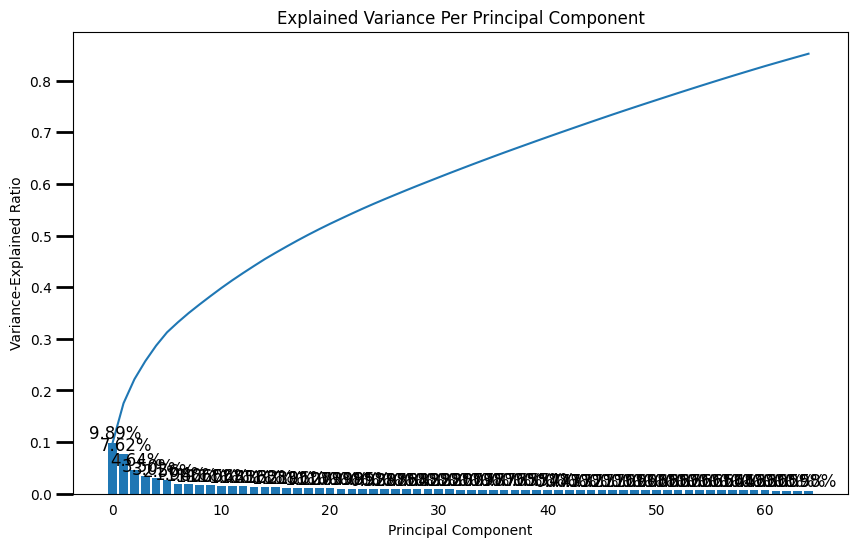

In [73]:
# Investigate the variance accounted for by each principal component.

scree_plot(pca,65)
print(pca.explained_variance_ratio_[:65])

In [74]:
# Re-apply PCA to the data while selecting for number of components to retain.
#65 principle components selected
pca = PCA(65)
genpop_pca = pca.fit_transform(genpop)


### Discussion 2.2: Perform Dimensionality Reduction

I began by fitting the data on a PCA object with components equal to half the total number of features (74). I borrowed the scree_plot function from the PCA course lessons to visualize the trend this produced. Immediately, it was obvious the first 6 components were contributing the most to the explained variance accounting for 31% of the datasets total variance by themselves.

Looking at cumulative sums of total variance explained and experimenting with differing numbers of principle components I obtained:<br>
74 components gives ~90% total variance explained.<br>
65 components gives ~85% total variance explained.<br>
20 components gives ~51% total variance explained.<br>

Some checking around let me know 80-90% explained variance generally strikes a good balance of explained variance vs dimensionality reduction so a value in-between (65 components) is what I settled on. The reduced set includes 65 variables whereas the preprocessed dataset included 148 variables resulting in a dimensionality reduction of more than 50%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [75]:
def weight_feature_mapping(df,pca,component):
    weights = pca.components_[component+1]
    feats = df.columns
    
    #using a dictionary to create tuples out of feature names and weights
    feats_weights = dict(zip(feats,weights))

    #sort tuples based on absolute value of weights. Largest magnitude features first
    sort_feats = sorted(feats_weights.items(),key = lambda x: abs(x[1]), reverse=True)

    return sort_feats


In [76]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
pca_1 = weight_feature_mapping(genpop,pca,1)
pca_1

[('ANREDE_KZ', -0.34555640136284094),
 ('SEMIO_VERT', 0.31933071146509756),
 ('SEMIO_KAEM', -0.31096214825711993),
 ('SEMIO_DOM', -0.28273508778314627),
 ('SEMIO_KRIT', -0.26839602084473935),
 ('SEMIO_FAM', 0.264454182789588),
 ('SEMIO_SOZ', 0.2584810225338739),
 ('SEMIO_KULT', 0.2552745992266316),
 ('SEMIO_ERL', -0.20331132157550275),
 ('FINANZ_ANLEGER', -0.1529365411032198),
 ('SEMIO_RAT', -0.15097344160688247),
 ('FINANZTYP_5', 0.1302452200808584),
 ('FINANZ_MINIMALIST', 0.12797741778343052),
 ('SEMIO_REL', 0.12584681612275103),
 ('ZABEOTYP_1', 0.12224514935376163),
 ('SHOPPER_TYP_0.0', 0.1197332259137701),
 ('SHOPPER_TYP_2.0', -0.10028636799638885),
 ('FINANZTYP_1', -0.09614878906428961),
 ('SEMIO_MAT', 0.0850433822157885),
 ('RETOURTYP_BK_S', 0.08110975202836306),
 ('MIN_GEBAEUDEJAHR', -0.07645822579597261),
 ('LP_STATUS_FEIN_2.0', -0.07542995347568031),
 ('GREEN_AVANTGARDE', 0.0727421550275044),
 ('PRAEGENDE_JUGENDJAHRE_MOVEMENT', 0.0727421550275044),
 ('W_KEIT_KIND_HH', 0.071552

In [77]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_2 = weight_feature_mapping(genpop,pca,2)
pca_2


[('GREEN_AVANTGARDE', 0.29391468476640525),
 ('PRAEGENDE_JUGENDJAHRE_MOVEMENT', 0.29391468476640525),
 ('LP_STATUS_FEIN_10.0', 0.24450747017602315),
 ('LP_STATUS_GROB_5.0', 0.24450747017602315),
 ('LP_STATUS_GROB_4.0', -0.22841056147199398),
 ('MIN_GEBAEUDEJAHR', -0.22256806291485448),
 ('LP_STATUS_FEIN_9.0', -0.20681459958715828),
 ('EWDICHTE', 0.1964279998011869),
 ('ORTSGR_KLS9', 0.1891716151138774),
 ('ANZ_PERSONEN', 0.16460018318122566),
 ('LP_FAMILIE_FEIN_1.0', -0.16240335981998963),
 ('LP_FAMILIE_GROB_1.0', -0.16240335981998963),
 ('BALLRAUM', -0.1565632326920547),
 ('HH_EINKOMMEN_SCORE', -0.15220328225458385),
 ('INNENSTADT', -0.1518245221263292),
 ('KKK', -0.14050177133471523),
 ('LP_FAMILIE_GROB_5.0', 0.1365673445710519),
 ('ONLINE_AFFINITAET', 0.1218499779838272),
 ('SEMIO_DOM', 0.12140498913397284),
 ('LP_STATUS_FEIN_4.0', -0.11202126407328353),
 ('KONSUMNAEHE', -0.10834250366467015),
 ('W_KEIT_KIND_HH', -0.10811093831495604),
 ('REGIOTYP', -0.10296493977920018),
 ('SEMIO_K

In [78]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_3 = weight_feature_mapping(genpop,pca,3)
pca_3

[('MIN_GEBAEUDEJAHR', 0.7805490274169632),
 ('FINANZTYP_3', 0.2033071495418497),
 ('LP_STATUS_FEIN_4.0', -0.13796152934051858),
 ('ZABEOTYP_2', 0.13640150531217451),
 ('LP_STATUS_GROB_2.0', -0.13307509990663355),
 ('GFK_URLAUBERTYP_2.0', 0.12358902888807949),
 ('FINANZ_HAUSBAUER', -0.11157681001711846),
 ('PLZ8_ANTG1', -0.11015243865492588),
 ('PLZ8_ANTG4', 0.10953560204232513),
 ('LP_FAMILIE_GROB_4.0', 0.10525729480856244),
 ('ORTSGR_KLS9', 0.10523478252597594),
 ('INNENSTADT', -0.09856073467531683),
 ('PLZ8_ANTG3', 0.09787196857001854),
 ('EWDICHTE', 0.09707803593014695),
 ('PLZ8_GBZ', -0.09608759145654709),
 ('MOBI_REGIO', -0.08506035869135578),
 ('LP_FAMILIE_FEIN_7.0', 0.08362154000532057),
 ('KBA05_ANTG4', 0.08227201383798514),
 ('KBA05_ANTG1', -0.08176458619849616),
 ('BALLRAUM', -0.08008123652754287),
 ('KBA05_GBZ', -0.0777618721209371),
 ('SHOPPER_TYP_0.0', -0.07635979536934032),
 ('W_KEIT_KIND_HH', -0.07583813256707884),
 ('ARBEIT', 0.0740034090782041),
 ('LP_STATUS_FEIN_8.0',

### Discussion 2.3: Interpret Principal Components

***Principle component 1***:<br>
Dominating decade of youth<br>
Money saver (Financial typology)<br>
Inconspicuous (Financial typology)<br>
opposed to:<br>
Be prepared (Financial typology)<br>
Estimated age based on given name<br>

All are of approximately the same magnitudes. Not clear on the differences in financial typology. This could possibly be related to age/generation as an underlying pattern.

***Principle component 2***:<br>
Dreamful (Personality typology)<br>
opposed to:<br>
Gender<br>
Combative attitude (Personality typology)<br>
Dominant-minded (Personality typology)<br>
Critical-minded (Personality typology)<br>

 Critical-minded and Dominant-minded have less magnitude than the others (all others over 0.3). Gender is the highest magnitude.
 Seems to be a pattern here, aggressive traits are represented in line with gender on one side and the more peaceful 'Dreamful' trait is aligned on the other side.

***Principle component 3***:<br>
Member of green advantgarde<br>
Dominating movement of youth<br>
Top earners (Social status)<br>
Minimalistic high-income earners (Social status)<br>
opposed to:<br>
Villagers (Social status)<br>

Member of green advantgarde and dominating movement of youth are higher magnitude than the others by a noticeable amount. Pattern is clearly social status here. Villagers opposed to features associated with higher societal class individuals.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [79]:
pd.DataFrame(genpop_pca).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
count,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05,7.489440e+05
mean,-9.282336e-17,8.902846e-17,-5.257271e-16,-1.101661e-16,1.960903e-15,-8.329815e-16,1.334099e-16,-2.963820e-16,-8.106675e-16,-4.078004e-16,-5.652890e-16,-6.471071e-16,3.876495e-16,-4.400097e-16,5.250630e-16,2.952625e-16,2.079987e-16,8.004165e-16,3.280695e-17,-5.876599e-16,1.287991e-16,3.627170e-16,4.655304e-16,-1.128984e-16,1.893572e-15,-6.941260e-16,1.887206e-16,-3.690355e-16,-2.148675e-16,-1.572419e-16,4.186728e-17,1.186496e-15,-2.929666e-17,9.298465e-17,-2.078469e-16,9.340968e-16,3.217035e-16,6.715273e-16,3.708665e-16,5.561527e-16,8.606606e-16,1.570331e-16,1.860831e-16,3.897082e-16,1.732469e-16,3.132219e-16,-4.038442e-16,6.356038e-16,-4.271544e-16,2.469724e-16,-3.296823e-17,3.691731e-16,6.435968e-16,-6.452286e-16,7.790749e-16,1.095968e-16,2.661841e-16,1.178413e-16,-1.239321e-16,-3.284490e-17,-7.731264e-16,9.653407e-16,-7.054490e-16,8.081629e-16,-1.147864e-16
std,3.836533e+00,3.367212e+00,2.628984e+00,2.281876e+00,2.119445e+00,1.954087e+00,1.700296e+00,1.638791e+00,1.573885e+00,1.546447e+00,1.525575e+00,1.487677e+00,1.449035e+00,1.425084e+00,1.409790e+00,1.354251e+00,1.334111e+00,1.317363e+00,1.290504e+00,1.265902e+00,1.242116e+00,1.215067e+00,1.209475e+00,1.193471e+00,1.172265e+00,1.153579e+00,1.138699e+00,1.135009e+00,1.123884e+00,1.111820e+00,1.108857e+00,1.106835e+00,1.094781e+00,1.091544e+00,1.086236e+00,1.081516e+00,1.076071e+00,1.064257e+00,1.060833e+00,1.058631e+00,1.055699e+00,1.050307e+00,1.046218e+00,1.043218e+00,1.040309e+00,1.033762e+00,1.030997e+00,1.024883e+00,1.018613e+00,1.016184e+00,1.009627e+00,1.007114e+00,1.003236e+00,1.001395e+00,9.966880e-01,9.922222e-01,9.861671e-01,9.824702e-01,9.776384e-01,9.686977e-01,9.654674e-01,9.516061e-01,9.436167e-01,9.414452e-01,9.389221e-01
min,-8.906800e+00,-9.819999e+00,-6.719684e+00,-8.189694e+00,-7.485238e+00,-7.198024e+00,-4.661578e+00,-7.125787e+00,-5.822330e+00,-5.932188e+00,-4.330303e+00,-7.440010e+00,-4.602750e+00,-6.114056e+00,-8.001923e+00,-6.579240e+00,-6.347490e+00,-5.766847e+00,-6.494549e+00,-4.691810e+00,-6.712688e+00,-8.514041e+00,-6.171030e+00,-5.262393e+00,-4.541852e+00,-9.447285e+00,-6.903992e+00,-6.357388e+00,-5.166864e+00,-4.937840e+00,-6.275701e+00,-6.351093e+00,-6.217054e+00,-6.278593e+00,-4.700891e+00,-5.939116e+00,-4.748373e+00,-5.983897e+00,-4.780338e+00,-4.778301e+00,-4.651158e+00,-5.091895e+00,-4.485786e+00,-8.848923e+00,-6.803519e+00,-1.138171e+01,-5.000331e+00,-7.502218e+00,-1.369525e+01,-5.839538e+00,-1.135496e+01,-5.680236e+00,-1.273491e+01,-5.367575e+00,-7.615290e+00,-7.100888e+00,-4.743035e+00,-9.030698e+00,-3.688733e+00,-6.001934e+00,-1.562156e+01,-7.179292e+00,-4.148025e+00,-6.781490e+00,-1.955025e+01
25%,-3.375885e+00,-2.752382e+00,-2.358193e+00,-1.601235e+00,-1.231775e+00,-1.324700e+00,-1.216019e+00,-1.092471e+00,-1.039199e+00,-1.051678e+00,-9.531953e-01,-9.723350e-01,-5.098318e-01,-1.011819e+00,-8.762745e-01,-9.012479e-01,-8.564855e-01,-8.674940e-01,-8.760752e-01,-6.807024e-01,-7.982892e-01,-7.889172e-01,-8.023444e-

In [80]:
""" average_distances = []
k_values = range(1,45)
# Over a number of different cluster counts...
for k in k_values:
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters = k, random_state=0)
    kmeans.fit(genpop_pca)
    # compute the average within-cluster distances.
    #kmeans score gives us a negative inertia value. taking the negative of this and calculating average as 
    #inertia divided by samples in the data set.
    score = -kmeans.score(genpop_pca)
    average_distances.append(score/genpop.shape[0])

# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(8, 5))
plt.plot(k_values, average_distances, marker='o')
plt.title('Number of clusters versus average distances to centroids')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Distance to Centroids')
plt.xticks(k_values, rotation = 45)
plt.grid()
plt.show() """
    

" average_distances = []\nk_values = range(1,45)\n# Over a number of different cluster counts...\nfor k in k_values:\n    # run k-means clustering on the data and...\n    kmeans = KMeans(n_clusters = k, random_state=0)\n    kmeans.fit(genpop_pca)\n    # compute the average within-cluster distances.\n    #kmeans score gives us a negative inertia value. taking the negative of this and calculating average as \n    #inertia divided by samples in the data set.\n    score = -kmeans.score(genpop_pca)\n    average_distances.append(score/genpop.shape[0])\n\n# Investigate the change in within-cluster distance across number of clusters.\n# HINT: Use matplotlib's plot function to visualize this relationship.\nplt.figure(figsize=(8, 5))\nplt.plot(k_values, average_distances, marker='o')\nplt.title('Number of clusters versus average distances to centroids')\nplt.xlabel('Number of Clusters (k)')\nplt.ylabel('Average Distance to Centroids')\nplt.xticks(k_values, rotation = 45)\nplt.grid()\nplt.show() 

In [81]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 23,random_state=0)
kmeans.fit_transform(genpop_pca)

predictions = kmeans.predict(genpop_pca)


<BarContainer object of 23 artists>

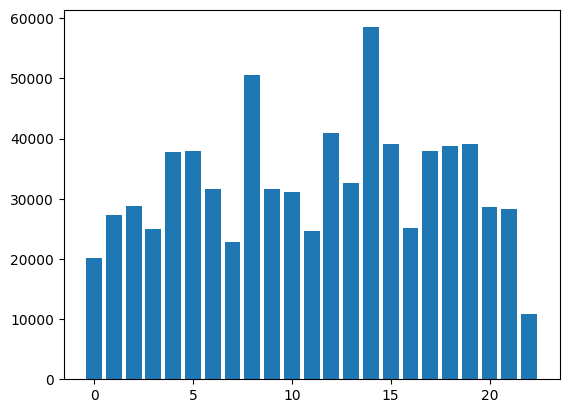

In [82]:
unique, counts = np.unique(predictions, return_counts=True)
plt.bar(unique, counts)


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [83]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')
custpop_col_list = customers.columns.tolist()

genpop_col_list == custpop_col_list

True

In [84]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [85]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#Additional functionality added to clean_data method to optionally handle removal of NaNs 
#After the Step 1 clean-up tasks have been performed.
custpop = clean_data(customers,handle_nans = True)


In [86]:
custpop.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,0.695345,-0.691442,0.712637,-0.495940,0.492276,-0.574838,0.220190,-0.596238,0.938625,-1.245832,0.912439,0.989979,0.689959,-0.798991,1.288020,0.467977,0.865827,-1.062023,0.041381,-1.332957,-0.490615,-1.892579,-1.392966,-0.644266,-1.339650,-0.099426,-1.003040,-0.299890,-0.138996,-1.376753,0.911490,0.272890,-0.283896,-0.132672,1.316455,-0.288355,0.288242,-0.172110,0.721255,-0.400011,-0.312294,0.317048,-0.598538,-1.202115,-0.388726,0.179899,-1.412746,0.280187,0.012290,-1.523666,1.602613,0.507338,0.305988,-0.452084,-0.851404,1.479191,1.379133,-1.826652,-1.465423,-1.353193,-0.441482,-0.647331,-0.448899,-0.470185,2.653769,-0.271149,-0.158528,1.557612,-0.140095,-0.112606,-0.726283,-0.664821,-0.250497,-0.160806,-0.340963,2.694260,-0.364828,-0.216155,-0.329149,-0.375954,-0.185502,-0.477491,-0.232177,-0.195328,-0.635433,1.947485,-0.030856,-0.057494,-0.07495,-0.067854,-0.126697,-0.173596,-0.1332,-0.600035,-0.439816,-0.635433,1.947485,-0.099647,-0.228534,-0.894069,-0.383096,-0.084663,-0.339429,-0.182791,-0.069757,-0.22061,-0.284832,-0.052262,-0.507008,1.23565,-0.395220,-0.404284,-0.371808,-0.51125,1.23565,0.163586,-0.129901,-0.097772,-0.554672,-0.577034,-0.443298,1.360702,-0.794603,-0.209000,1.164710,-0.347219,-0.080415,-0.184025,0.685957,0.0,-0.449442,0.0,0.0,-0.423250,2.647465,-0.438724,-0.379004,-0.431640,-0.296053,-0.398154,-0.284601,-0.325441,-0.211868,-0.640226,0.938625,-1.140343,-0.296595
1,0.695345,1.446252,0.712637,-0.495940,0.492276,-0.574838,2.373089,0.952626,0.938625,0.059970,0.912439,-1.494095,-1.120299,-1.504554,-0.200944,-1.261463,0.865827,1.207390,-1.669115,-0.593291,1.759862,0.614887,1.362972,0.775753,-1.339650,-0.099426,0.9969

In [91]:
#custpop_pca = pca.transform(custpop)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- GEBAEUDETYP_5.0


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [72]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [73]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [74]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.